# Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# In order to import pynput you need to run these files to make virtual env

!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &') # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 784 kB in 2s (418 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.9_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.9) ...
Setting up xvfb (2:1.19.6-1ubuntu4.9) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!pip install git+https://github.com/capi-bgu/oratio.git -qqq
!pip install -Uqq pynput==1.6.8
!pip install -Uqq wandb

     |████████████████████████████████| 92kB 3.7MB/s 
     |████████████████████████████████| 184kB 8.2MB/s 
     |████████████████████████████████| 1.8MB 4.3MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 133kB 52.6MB/s 
     |████████████████████████████████| 174kB 47.9MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 


In [ ]:
!git clone https://github.com/capi-bgu/Research.git

Cloning into 'Research'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (332/332), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 332 (delta 150), reused 240 (delta 86), pack-reused 0
Receiving objects: 100% (332/332), 744.53 KiB | 4.48 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [ ]:
import numpy as np
import pickle
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras

from Research.util.data_loading import *
from Research.util.evaluate import *
from Research.models.emotionnet_nano import *
from Research.models.frame_attention import *
from oratio.Session import Session

# Load Classic Models

In [ ]:
import zipfile
import os
#takes 1:40 minutes
participants = os.listdir('/content/drive/MyDrive/capi/results/')
sizes = ["1","5","10"]
for participant in participants:
  os.makedirs(participant)
  for size in sizes:
    try:
      with zipfile.ZipFile(f'/content/drive/MyDrive/capi/results/{participant}/{size}.zip', 'r') as zip_ref:
        zip_ref.extractall(f'/content/{participant}')
    except:
      print(f'I didnt find {participant} with the size {size}')

# Face Data

In [ ]:
def create_dataset(dataframe, sequence_length=None, resize_to=None, labels=("categorical"), test_split=0.1, val_split=None, random_state=None, category_encoder=None):
  if category_encoder is None:
    category_encoder = LabelEncoder()
    category_encoder.fit(dataframe["categorical"])
  dataframe["categorical"] = category_encoder.transform(dataframe["categorical"])
  raw_labels = dataframe[labels].values.astype(np.int)
  raw_data = dataframe["images"].values

  for i, images in enumerate(raw_data):
    if resize_to is not None:
      images = np.array(images)
      resized_images = np.zeros(shape=((len(images), ) + resize_to))
      for j, image in enumerate(images):  
        resized_images[j] = cv2.resize(image, resize_to)
      raw_data[i] = resized_images
    else:
      raw_data[i] = np.array(images)
  
  train_data, test_data, train_labels, test_labels = train_test_split(raw_data,
                                                                      raw_labels,
                                                                      test_size=test_split,
                                                                      random_state=random_state)
  if val_split is not None:
    train_data, val_data, train_labels, val_labels = train_test_split(train_data,
                                                                      train_labels,
                                                                      test_size=val_split,
                                                                      random_state=random_state)

  if sequence_length is not None:
    unwraped_train_data = generate_sequences(train_data[0], sequence_length)
    unwraped_test_data = generate_sequences(test_data[0], sequence_length)
    if val_split is not None:
      unwraped_val_data = generate_sequences(val_data[0], sequence_length)
  else:
    unwraped_train_data = train_data[0]
    unwraped_test_data = test_data[0]
    if val_split is not None:
      unwraped_val_data = test_data[0]

  unwraped_train_labels = np.repeat(np.expand_dims(train_labels[0], axis=0), len(unwraped_train_data), axis=0)
  unwraped_test_labels = np.repeat(np.expand_dims(test_labels[0], axis=0), len(unwraped_test_data), axis=0)
  if val_split is not None:
    unwraped_val_labels = np.repeat(np.expand_dims(val_labels[0], axis=0), len(unwraped_val_data), axis=0)

  
  for i in range(1, len(train_data)):
    if sequence_length is not None:
      train_examples = generate_sequences(train_data[i], sequence_length)
      if train_examples is None:
        continue
    else:
      train_examples = train_data[i]
    unwraped_train_data = np.concatenate((unwraped_train_data, train_examples))
    unwraped_train_labels = np.concatenate(
        (
          unwraped_train_labels,
          np.repeat(np.expand_dims(train_labels[i], axis=0), len(train_examples), axis=0)
        )
    )

  for i in range(1, len(test_data)):
    if sequence_length is not None:
      test_examples = generate_sequences(test_data[i], sequence_length)
      if test_examples is None:
        continue
    else:
      test_examples = test_data[i]
    unwraped_test_data = np.concatenate((unwraped_test_data, test_examples))
    unwraped_test_labels = np.concatenate(
      (
        unwraped_test_labels,
        np.repeat(np.expand_dims(test_labels[i], axis=0), len(test_examples), axis=0)
      )
    )
  
  if val_split is not None:
    for i in range(1, len(val_data)):
      if sequence_length is not None:
        val_examples = generate_sequences(val_data[i], sequence_length)
        if val_examples is None:
          continue
      else:
        val_examples = val_data[i]
      unwraped_val_data = np.concatenate((unwraped_val_data, val_examples))
      unwraped_val_labels = np.concatenate(
        (
          unwraped_val_labels,
          np.repeat(np.expand_dims(val_labels[i], axis=0), len(val_examples), axis=0)
        )
      )
      
  res = (unwraped_train_data / 255, unwraped_test_data / 255)
  if val_split is not None:
    res += (unwraped_val_data / 255, )
  
  res += (unwraped_train_labels, unwraped_test_labels)
  if val_split is not None:
    res += (unwraped_val_labels, )

  if "categorical" in labels:
    return res, category_encoder
  
  return res

def generate_sequences(arr, sequence_length):
  if len(arr) < sequence_length:
    return None
  sequences = np.zeros(shape=(len(arr) - (sequence_length - 1), sequence_length) + arr.shape[1:])
  for i in range(len(arr) - (sequence_length - 1)):
    sequences[i] = arr[i:i+sequence_length]
  
  return sequences

# Keyboard and Mouse Data

In [ ]:
from sklearn.model_selection import train_test_split

def load_data(data_path, resources_path, channels, duration):
  data = load_features(data_path, channels, duration, resources_path)
  labels = ["categorical", "valance", "arousal", "dominance", "positive"]
  y = data[labels]
  X = data.drop(columns=["session", "time"] + labels)
  X["dominate_window"] = X["dominate_window"].astype('category').cat.codes.astype(np.uint32)
  X["dominate_task"] = X["dominate_task"].astype('category').cat.codes.astype(np.uint32)
  for column in X:
      if "Turn" in column or \
              "count" in column or \
              "switches" in column or \
              "mode_key" in column or \
              "Direction" in column or \
              "unique_events" in column or \
              "error_corrections" in column:
          X[column] = X[column].astype(np.uint32)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
  return X, X_train, X_test, y, y_train, y_test

#Ensemble

In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 0.24.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, scipy, threadpoolctl, joblib
Required-by: yellowbrick, sklearn, sklearn-pandas, mlxtend, lightgbm, librosa, imbalanced-learn


In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 68.2MB/s 


In [ ]:
pd.options.display.latex.repr = True
pd.options.display.max_columns = None
channels = ["Both", "Keyboard", "Mouse"]
categorical_algorithms = ["AdaBoost","bagging","decision_tree","knn","linear_svm","logistic_regression","random_forest","voting"]
categorical_labels = ["categorical", "positive"]
regression_algorithms = ["AdaBoost_reg","ElasticNet","Lars","bagging_reg","knn_reg","lasso","random_forest_reg","ridge","svr","voting"]
regression_labels = ["arousal", "dominance", "valance"]
participants = os.listdir('/content/drive/MyDrive/capi/results/')
all_labels = ["categorical", "positive","arousal", "dominance", "valance"]
classification_param = "accuracy" # balanced_accuracy
regression_param = "mean absolute error" # mean squared error
session_sizes = ["1","5","10"]

def get_best_n_models(n):
  results_dict = {}
  for channel in channels:
    results_dict[channel] = {}
    for size in session_sizes:
      for label in categorical_labels:
        if label not in results_dict[channel]:
          results_dict[channel][label] = {}
        best_participants_model = pd.DataFrame(columns = ['participant','model', 'accuracy', 'balanced accuracy'])
        for participant in [p for p in participants if os.path.isdir(f'{p}/{size}')]:
          best_n_score = [-100 for i in range(n)]
          best_n_models = []
          for algorithm in categorical_algorithms:
            with open(f'{participant}/{size}/{channel}/{label}/{algorithm}/pickled_scores.df', 'rb') as handle:
                df = pickle.load(handle)
                score = df[classification_param][1] - df[classification_param][0]
                for i in range(n):
                  if score > best_n_score[i]:
                    df.insert(loc=0, column="participant",value=participant)
                    best_n_score.insert(i,score)
                    best_n_score = best_n_score[:n]
                    best_model = df.iloc[1][:4]
                    for j in range(2,len(best_model)):
                      best_model[j] = f'{df.iloc[1, j]:0.2f} / {df.iloc[0, j]:0.2f}'
                    best_n_models.insert(i, best_model)
                    best_n_models = best_n_models[:n]
                    break
          best_participants_model = best_participants_model.append(best_n_models)
        results_dict[channel][label][size] = best_participants_model
      for label in regression_labels:
        if label not in results_dict[channel]:
          results_dict[channel][label] = {}
        best_participants_model = pd.DataFrame(columns = ['participant','model', 'mean absolute error', 'mean squared error'])
        for participant in [p for p in participants if os.path.isdir(f'{p}/{size}')]:
          best_n_score = [-100 for i in range(n)]
          best_n_models = []
          for algorithm in regression_algorithms:
            with open(f'{participant}/{size}/{channel}/{label}/{algorithm}/pickled_scores.df', 'rb') as handle:
                df = pickle.load(handle)
                score = df[regression_param][0] - df[regression_param][1]
                for i in range(n):
                  if score > best_n_score[i]:
                    df.insert(loc=0, column="participant",value=participant)
                    best_n_score.insert(i,score)
                    best_n_score = best_n_score[:n]
                    best_model = df.iloc[1][:4]
                    for j in range(2,len(best_model)):
                      best_model[j] = f'{df.iloc[1, j]:0.2f} / {df.iloc[0, j]:0.2f}'
                    best_n_models.insert(i, best_model)
                    best_n_models = best_n_models[:n]
                    break
          best_participants_model = best_participants_model.append(best_n_models)
        results_dict[channel][label][size] = best_participants_model
  return results_dict

In [ ]:
def get_participant_kb_mouse_data(name):
  if os.path.isfile(f'/content/drive/MyDrive/capi/data/public/{name}.db'):
    data_path = f'/content/drive/MyDrive/capi/data/public/{name}.db'
  else:
    data_path = f'/content/drive/MyDrive/capi/data/public/{name}-no_images.db'
  _, _, test_data, _, _, test_labels = load_data(data_path, "/content/drive/MyDrive/capi/models", ["Mouse","Keyboard"], 10)
  return test_data, test_labels

In [ ]:
def get_participant_data(name, input_channels):
  if os.path.isfile(f'/content/drive/MyDrive/capi/data/public/{name}.db'):
    print(" I load ", name)
    data_path = f'/content/drive/MyDrive/capi/data/public/{name}.db'
  else:
    print(" I didn't find",name, " has camera so I return None None")
    return None, None # We return None because we only want people with image
  _, _, test_data, _, _, test_labels = load_data(data_path, "/content/drive/MyDrive/capi/models", input_channels, 10)
  return test_data, test_labels

In [ ]:
def load_nn_model(name, label_type, duration):
  if label_type == "categorical":
    label_type = "cat"
  elif label_type == "positive":
    label_type = "pos"
  elif label_type == "regression":
    label_type = "reg"

  nn_model = emotion_nano_b()
  nn_model.load_weights(f"/content/drive/MyDrive/capi/models/frame_attention/emotionnet-nano_{label_type}-{name}-{duration}/")
  return nn_model


def mean_aggregator(probs):
  return np.mean(probs, axis=0)

def predict_probs_nn(model, data, session_aggregator=mean_aggregator):
  all_probs = []
  for session_images in data:
    session_pred = model(session_images)
    all_probs.append(session_aggregator(session_pred))
  return np.array(all_probs)

In [ ]:
def ensemble_predictions(nn_pred, clf_pred, test_labels, category_encoder):
  if nn_pred.shape[1] != clf_pred.shape[1]:
    nn_pred = nn_pred[:,:-1]
  predictions = category_encoder.inverse_transform(np.argmax((nn_pred + clf_pred)/2, axis=1))
  return clf_scores(test_labels["categorical"], predictions)

In [ ]:
def nn_predictions(nn_pred, test_labels):
  predictions = category_encoder.inverse_transform(np.argmax(nn_pred, axis=1))
  return clf_scores(test_labels["categorical"], predictions)

In [ ]:
def nn_prepare_images(test_data):
  test_images = test_data["images"].to_numpy(copy=True)
  for i, images in enumerate(test_images):
    resized_images = np.zeros(shape=(len(images), 48, 48))
    for j, image in enumerate(images):  
          resized_images[j] = cv2.resize(image, (48, 48)) / 255
    test_images[i] = resized_images
  return test_images

In [ ]:
def fix_clf_pred(clf_pred, category_encoder):
  all_labels = category_encoder.inverse_transform(range(len(category_encoder.classes_)))
  clf_labels = clf_model.classes_
  for i,label in enumerate(all_labels):
    if label not in clf_labels:
      clf_pred = np.insert(clf_pred, i, 0, axis=1)
  return clf_pred

In [ ]:
def predict_ensemble(prob_list, test_labels, category_encoder, use_average = True):
  nn_weight = 0.7
  nn_pred = prob_list[0] # the nn predictions is always the first one
  clf_pred = prob_list[1] # the others are the clf preds
  if nn_pred.shape[1] != clf_pred.shape[1]: # check if we don't have 6 labels
    prob_list[0] = prob_list[0][:,:-1]
  if use_average:
    if len(prob_list) == 7:
      all_prob = np.average(np.array(prob_list),axis=0, weights=np.array([0.7,0.07,0.05,0.03,0.07,0.05,0.03]))
    else:
      all_prob = np.average(np.array(prob_list),axis=0, weights=np.array([0.7,0.14,0.10,0.06]))
  else:
    all_prob = np.max(np.array(prob_list), axis=0)
  predictions = category_encoder.inverse_transform(np.argmax(all_prob, axis=1))
  return clf_scores(test_labels["categorical"], predictions)[:2]

In [ ]:
results_dict = get_best_n_models(5)

In [ ]:
# takes 2.20 mins
participants_data = {}
for participant in participants:
  if participant == "shoham": # this man doesn't have camera model
    participants_data[participant] = (None, None)
    continue
  all_test_data, all_test_labels = get_participant_data(participant,["Mouse","Keyboard","Camera"])
  participants_data[participant] = (all_test_data, all_test_labels)

 I load  niv
 I load  shiran
 I load  tal
 I load  liraz
 I didn't find shira  has camera so I return None None
 I load  ron
 I load  yuval
 I didn't find amit  has camera so I return None None


This is only for people that have camera

In [ ]:
import warnings
import collections
warnings.filterwarnings('ignore')  # ignore warning from sklearn
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # to remove the annoying tf warnings (like 1000 lines)
#takes 2 minutes
duration = "10"
label = "categorical"
kb_participant_models = results_dict["Keyboard"][label][duration]
mouse_participant_models = results_dict["Mouse"][label][duration]
both_participant_models = results_dict["Both"][label][duration]
models_accuracy = {}
for participant in participants:
  all_test_data = participants_data[participant][0]
  all_test_labels = participants_data[participant][1]
  if all_test_data is None:
    continue
  print("Ensemble for ", participant)
  mouse_test_data = all_test_data.loc[:, 'right_click_count':'task_count']	
  keyboard_features = all_test_data.loc[:, 'active_typing_speed':'unique_events']
  meta_features = all_test_data.loc[:, 'dominate_window':'task_count']
  kb_test_data = pd.concat([keyboard_features,meta_features],axis=1)
  both_test_data = all_test_data.drop('images',axis=1)
  features = load_features(f"/content/drive/MyDrive/capi/data/public/{participant}.db", "Camera", int(duration))
  _, category_encoder = create_dataset(features, resize_to=(48, 48), test_split=0.2, random_state=42)
  nn_model = load_nn_model(participant, label, int(duration))
  test_images = nn_prepare_images(all_test_data)
  nn_pred = predict_probs_nn(nn_model, test_images)
  nn_acc = nn_predictions(nn_pred, all_test_labels)[:2]
  all_prob_pred = [nn_pred]
  best_kb_pred = []
  best_mouse_pred = []
  best_both_pred = []
  models_added = 0
  for algorithm in kb_participant_models.loc[kb_participant_models['participant'] == participant]["model"]:
    if algorithm == "voting" or algorithm == "voting ensamble" or algorithm == "linear_svm": # these algorithms can't use predict_proba
      continue
    kb_clf_model = pickle.load(open(f'{participant}/{duration}/Keyboard/{label}/{algorithm}/model.md','rb'))
    kb_clf_pred = kb_clf_model.predict_proba(kb_test_data)
    kb_clf_pred = fix_clf_pred(kb_clf_pred,category_encoder) # sometimes we don't have all the feelings
    all_prob_pred += [kb_clf_pred]
    if models_added == 0: # this is the best model
      best_kb_pred += [kb_clf_pred]
    models_added += 1
    if models_added >= 3:
      break
  models_added = 0
  for algorithm in mouse_participant_models.loc[mouse_participant_models['participant'] == participant]["model"]:
    if algorithm == "voting" or algorithm == "voting ensamble" or algorithm == "linear_svm": # these algorithms can't use predict_proba
      continue
    mouse_clf_model = pickle.load(open(f'{participant}/{duration}/Mouse/{label}/{algorithm}/model.md','rb'))
    mouse_clf_pred = mouse_clf_model.predict_proba(mouse_test_data)
    mouse_clf_pred = fix_clf_pred(mouse_clf_pred,category_encoder) # sometimes we don't have all the feelings
    all_prob_pred += [mouse_clf_pred]
    if models_added == 0: # this is the best model
      best_mouse_pred += [mouse_clf_pred]
    models_added += 1
    if models_added >= 3:
      break
  models_added = 0
  for algorithm in both_participant_models.loc[both_participant_models['participant'] == participant]["model"]:
    if algorithm == "voting" or algorithm == "voting ensamble" or algorithm == "linear_svm": # these algorithms can't use predict_proba
      continue
    both_clf_model = pickle.load(open(f'{participant}/{duration}/Both/{label}/{algorithm}/model.md','rb'))
    both_clf_pred = both_clf_model.predict_proba(both_test_data)
    both_clf_pred = fix_clf_pred(both_clf_pred,category_encoder) # sometimes we don't have all the feelings
    if models_added == 0: # this is the best model
      best_both_pred += [both_clf_pred]
    models_added += 1
    if models_added >= 3:
      break
  most_common_label = collections.Counter(all_test_labels["categorical"]).most_common(1)[0][0]
  majority_pred = np.array([most_common_label for i in range(len(all_test_labels))])
  majority_acc = clf_scores(all_test_labels["categorical"],majority_pred)[:2]
  both_acc = clf_scores(all_test_labels["categorical"],both_clf_model.predict(both_test_data))[:2]
  mouse_acc = clf_scores(all_test_labels["categorical"],mouse_clf_model.predict(mouse_test_data))[:2]
  kb_acc = clf_scores(all_test_labels["categorical"],kb_clf_model.predict(kb_test_data))[:2]
  avg_ens_acc = predict_ensemble(all_prob_pred,all_test_labels, category_encoder, use_average=True)
  max_ens_acc = predict_ensemble(all_prob_pred,all_test_labels, category_encoder, use_average=False)
  print("nn accuracy: " , nn_acc)
  print("kb accuracy: " , kb_acc)
  print("mouse accuracy: " , mouse_acc)
  print("both accuracy: " , both_acc)
  print("average ensemble accuracy: " ,avg_ens_acc)
  print("max ensemble accuracy: " ,max_ens_acc)
  models_accuracy[participant] = {'nn_acc': nn_acc, 
                                  'avg_ens_acc': avg_ens_acc, 
                                  'max_ens_acc': max_ens_acc, 
                                  'both_acc':both_acc, 
                                  'mouse_acc':mouse_acc, 
                                  'kb_acc':kb_acc,
                                  'majority_acc':majority_acc}

In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, numpy, joblib
Required-by: yellowbrick, sklearn, sklearn-pandas, mlxtend, lightgbm, librosa, imbalanced-learn


This is for everyone

In [ ]:
import warnings
import collections
warnings.filterwarnings('ignore')  # ignore warning from sklearn
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # to remove the annoying tf warnings (like 1000 lines)
#takes 2 minutes
duration = "10"
label = "valance"
kb_participant_models = results_dict["Keyboard"][label][duration]
mouse_participant_models = results_dict["Mouse"][label][duration]
both_participant_models = results_dict["Both"][label][duration]
models_accuracy = {}
for participant in participants:
  all_test_data, all_test_labels = get_participant_kb_mouse_data(participant)
  mouse_test_data = all_test_data.loc[:, 'right_click_count':'task_count']	
  keyboard_features = all_test_data.loc[:, 'active_typing_speed':'unique_events']
  meta_features = all_test_data.loc[:, 'dominate_window':'task_count']
  kb_test_data = pd.concat([keyboard_features,meta_features],axis=1)
  both_test_data = all_test_data
  best_kb_pred = []
  best_mouse_pred = []
  best_both_pred = []
  models_added = 0
  for algorithm in kb_participant_models.loc[kb_participant_models['participant'] == participant]["model"]:
    if algorithm == "voting" or algorithm == "voting ensamble" or algorithm == "linear_svm": # these algorithms can't use predict_proba
      continue
    kb_clf_model = pickle.load(open(f'{participant}/{duration}/Keyboard/{label}/{algorithm}/model.md','rb'))
    if label in categorical_labels:
      kb_clf_pred = kb_clf_model.predict_proba(kb_test_data)
      kb_clf_pred = fix_clf_pred(kb_clf_pred,category_encoder) # sometimes we don't have all the feelings
    else:
      kb_clf_pred = kb_clf_model.predict(kb_test_data)
    if models_added == 0: # this is the best model
      best_kb_pred += [kb_clf_pred]
    models_added += 1
    if models_added >= 3:
      break
  models_added = 0
  for algorithm in mouse_participant_models.loc[mouse_participant_models['participant'] == participant]["model"]:
    if algorithm == "voting" or algorithm == "voting ensamble" or algorithm == "linear_svm": # these algorithms can't use predict_proba
      continue
    mouse_clf_model = pickle.load(open(f'{participant}/{duration}/Mouse/{label}/{algorithm}/model.md','rb'))
    if label in categorical_labels:
      mouse_clf_pred = mouse_clf_model.predict_proba(mouse_test_data)
      mouse_clf_pred = fix_clf_pred(mouse_clf_pred,category_encoder) # sometimes we don't have all the feelings
    else:
      mouse_clf_pred = mouse_clf_model.predict(mouse_test_data)
    if models_added == 0: # this is the best model
      best_mouse_pred += [mouse_clf_pred]
    models_added += 1
    if models_added >= 3:
      break
  models_added = 0
  for algorithm in both_participant_models.loc[both_participant_models['participant'] == participant]["model"]:
    if algorithm == "voting" or algorithm == "voting ensamble" or algorithm == "linear_svm": # these algorithms can't use predict_proba
      continue
    both_clf_model = pickle.load(open(f'{participant}/{duration}/Both/{label}/{algorithm}/model.md','rb'))
    if label in categorical_labels:
      both_clf_pred = both_clf_model.predict_proba(both_test_data)
      both_clf_pred = fix_clf_pred(both_clf_pred,category_encoder) # sometimes we don't have all the feelings
    else:
      both_clf_pred = mouse_clf_model.predict(mouse_test_data)
    if models_added == 0: # this is the best model
      best_both_pred += [both_clf_pred]
    models_added += 1
    if models_added >= 3:
      break
  if label in categorical_labels:
    most_common_label = collections.Counter(all_test_labels[label]).most_common(1)[0][0]
    majority_pred = np.array([most_common_label for i in range(len(all_test_labels))])
    majority_acc = clf_scores(all_test_labels[label],majority_pred)[:2]
    both_acc = clf_scores(all_test_labels[label],both_clf_model.predict(both_test_data))[:2]
    mouse_acc = clf_scores(all_test_labels[label],mouse_clf_model.predict(mouse_test_data))[:2]
    kb_acc = clf_scores(all_test_labels[label],kb_clf_model.predict(kb_test_data))[:2]
  else:
    majority_pred = np.array([np.average(all_test_labels[label]) for i in range(len(all_test_labels))]) 
    majority_acc = reg_scores(all_test_labels[label],majority_pred)[:2]
    both_acc = reg_scores(all_test_labels[label],both_clf_model.predict(both_test_data))[:2]
    mouse_acc = reg_scores(all_test_labels[label],mouse_clf_model.predict(mouse_test_data))[:2]
    kb_acc = reg_scores(all_test_labels[label],kb_clf_model.predict(kb_test_data))[:2]
  print("kb accuracy: " , kb_acc)
  print("mouse accuracy: " , mouse_acc)
  print("both accuracy: " , both_acc)
  models_accuracy[participant] = {'both_acc':both_acc, 
                                  'mouse_acc':mouse_acc, 
                                  'kb_acc':kb_acc,
                                  'majority_acc':majority_acc}

kb accuracy:  [('mean absolute error', 1.2650759300757934), ('mean squared error', 3.0225525606497707)]
mouse accuracy:  [('mean absolute error', 1.114750708870311), ('mean squared error', 2.4351690627650675)]
both accuracy:  [('mean absolute error', 1.1142588877873634), ('mean squared error', 2.6209700508131935)]
kb accuracy:  [('mean absolute error', 1.1880134654105259), ('mean squared error', 2.1932020580920244)]
mouse accuracy:  [('mean absolute error', 1.1206818181818183), ('mean squared error', 2.022620568181819)]
both accuracy:  [('mean absolute error', 1.1106494472723392), ('mean squared error', 2.1785415947695688)]
kb accuracy:  [('mean absolute error', 0.6317134350994666), ('mean squared error', 0.7175583075324463)]
mouse accuracy:  [('mean absolute error', 0.5970279720279721), ('mean squared error', 0.7149341043571812)]
both accuracy:  [('mean absolute error', 0.5907066993732885), ('mean squared error', 0.6321575934487744)]
kb accuracy:  [('mean absolute error', 2.2082709333

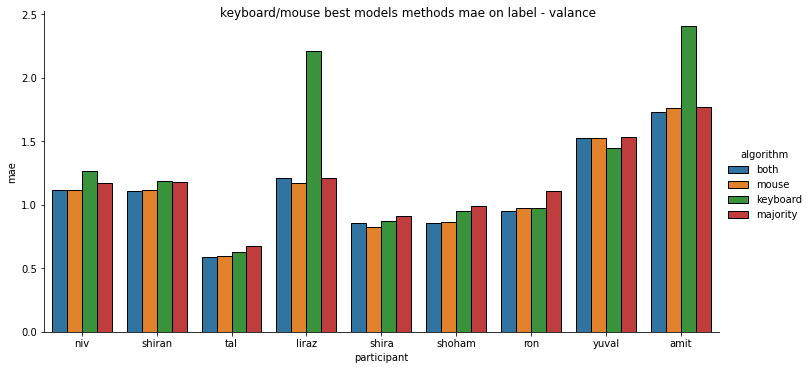

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

people = []
accuracy = []
for participant,algorithm  in models_accuracy.items():
  people += [participant] * len(algorithm)
  accuracy += [accs[0][1] for accs in list(models_accuracy[participant].values())]
if label in categorical_labels:
  participants_acc_db = pd.DataFrame(columns=["algorithm","participant","acc"])
else:
  participants_acc_db = pd.DataFrame(columns=["algorithm","participant","mae"])
participants_acc_db['algorithm'] = [#"nn_camera",
                                    #"avg_ens",
                                    #"max_ens",
                                    "both",
                                    "mouse",
                                    "keyboard",
                                    "majority"] * len(models_accuracy.keys())
participants_acc_db['participant'] = people
if label in categorical_labels:
  participants_acc_db['acc'] = accuracy
  ax = sns.catplot(x="participant",y="acc",hue="algorithm",data=participants_acc_db,kind='bar',aspect=2,edgecolor="black")
  ax.fig.suptitle(f'keyboard/mouse best models methods accuracy on label - {label}')
else:
  participants_acc_db['mae'] = accuracy
  ax = sns.catplot(x="participant",y="mae",hue="algorithm",data=participants_acc_db,kind='bar',aspect=2,edgecolor="black")
  ax.fig.suptitle(f'keyboard/mouse best models methods mae on label - {label}')